In [2]:
import statsmodels.api as sm #for OLS regression
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt #for heatmap plotting
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns #for heatmap plotting
from statsmodels.iolib.summary2 import summary_col #to summarize multiple regressions in one table
from datetime import date
from dateutil.relativedelta import relativedelta
import math
from scipy import stats

In [3]:
pf_size = pd.read_csv('data/Portfolios_Formed_on_ME_daily.csv')
ff5 = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_daily.csv')

In [4]:
pf_size.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)
ff5.rename(columns = {'Unnamed: 0': 'YYMM'}, inplace = True)

In [5]:
#to convert to decile format and get excess returns
pf_size_excess=(pf_size.iloc[:,1:pf_size.shape[1]]).sub(ff5.RF,axis=0)
print(pf_size_excess.head())

      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.878  
2  0.618  0.598  0.528  0.388  0.768  0.548  0.648  0.618  0.638  
3  0.468  0.168  0.378  0.398  0.328  0.278  0.278  0.298  0.458  
4 -0.232 -0.592 -0.872 -0.652 -0.612 -0.312 -0.402 -0.482 -0.712  


In [6]:
ff5['YYMM'] = pd.to_datetime(ff5['YYMM'],yearfirst=True, format='%Y%m%d')
pf_size_excess['YYMM'] = pd.to_datetime(pf_size['YYMM'],yearfirst=True, format='%Y%m%d')
print(ff5.head())
print(pf_size_excess.head())

        YYMM  Mkt-RF   SMB   HML   RMW   CMA     RF
0 1963-07-01   -0.67  0.00 -0.32 -0.01  0.15  0.012
1 1963-07-02    0.79 -0.27  0.27 -0.07 -0.19  0.012
2 1963-07-03    0.63 -0.17 -0.09  0.17 -0.33  0.012
3 1963-07-05    0.40  0.08 -0.28  0.08 -0.33  0.012
4 1963-07-08   -0.63  0.04 -0.18 -0.29  0.13  0.012
      <= 0  Lo 30  Med 40  Hi 30  Lo 20  Qnt 2  Qnt 3  Qnt 4  Hi 20  Lo 10  \
0 -100.002 -0.592  -0.552 -0.682 -0.622 -0.702 -0.482 -0.572 -0.692 -0.652   
1 -100.002  0.428   0.578  0.838  0.488  0.608  0.528  0.708  0.838  0.368   
2 -100.002  0.538   0.568  0.638  0.508  0.558  0.608  0.608  0.638  0.398   
3 -100.002  0.318   0.328  0.418  0.398  0.278  0.358  0.278  0.428  0.348   
4 -100.002 -0.442  -0.542 -0.642 -0.362 -0.752 -0.632 -0.372 -0.672 -0.482   

   2-Dec  3-Dec  4-Dec  5-Dec  6-Dec  7-Dec  8-Dec  9-Dec  Hi 10       YYMM  
0 -0.592 -0.552 -0.822 -0.562 -0.422 -0.532 -0.602 -0.702 -0.692 1963-07-01  
1  0.608  0.318  0.848  0.488  0.548  0.538  0.808  0.638  0.87

In [7]:
#change timestamps to index and delete unnecessary columns
ff5.index = ff5['YYMM']
pf_size_excess.index = pf_size_excess['YYMM']
ff5 = ff5.drop('YYMM', axis = 1)
# pf_size_excess = pf_size_excess.drop('YYMM', axis = 1)
ff5 = ff5.drop('RF', axis = 1)
#choose the size cut method
pf_size_excess = pf_size_excess.loc[:,['Lo 30','Med 40','Hi 30']]
print(pf_size_excess.head())

            Lo 30  Med 40  Hi 30
YYMM                            
1963-07-01 -0.592  -0.552 -0.682
1963-07-02  0.428   0.578  0.838
1963-07-03  0.538   0.568  0.638
1963-07-05  0.318   0.328  0.418
1963-07-08 -0.442  -0.542 -0.642


In [9]:
us_crisis_1 = ['1973-10-19', '1975-2-28', 'OPEC Oil Embargo']
us_crisis_2 = ['1981-1-1', '1982-6-30', 'US Recession of 1981-1982']
us_crisis_3 = ['1989-9-30', '1991-3-30', 'Junk Bonk Crash/S&L Crisis']
us_crisis_4 = ['2001-9-11', '2003-6-30', '911 Attack']
us_crisis_5 = ['2007-8-1', '2009-7-1', '2008 Financial Crisis']
us_crisis_6 = ['2018-12-1', '2019-5-30', 'China-US Trade War']

other_crisis_1 = ['1997-9-1', '1998-6-30', 'Asia Crisis']
other_crisis_2 = ['1997-9-1', '1998-12-30', 'Russia Crisis']
other_crisis_3 = ['2001-1-1','2001-12-30', 'Dotcom Bubble Burst']
other_crisis_4 = ['2010-1-1', '2012-6-30', 'European Debt Crisis']
other_crisis_5 = ['2015-6-12','2015-10-30', 'Chinese Market Crash']
other_crisis_6 = ['2015-1-1', '2015-12-30', 'Swiss Franc Shock']

# us_crisis_1 = ['1973-10-19', '1974-12-30', 'OPEC Oil Embargo']
# us_crisis_2 = ['1980-1-1', '1980-5-30', 'US Recession of 1980']
# us_crisis_2 = ['1981-8-1', '1982-10-30', 'US Recession of 1981-1982']
# us_crisis_3 = ['1990-7-1', '1991-2-28', 'Junk Bonk Crash/S&L Crisis']
# us_crisis_4 = ['2001-9-11', '2003-6-30', '911 Attack']
# us_crisis_5 = ['2007-8-1', '2009-7-1', '2008 Financial Crisis']
# us_crisis_6 = ['2018-12-1', '2019-5-30', 'China-US Trade War']


print(us_crisis_1[1])

1975-2-28


In [20]:
start = ff5.index[0]
end = ff5.index[ff5.shape[0]-1]
# print(end)
# window = 6
# t1 = start + relativedelta(months =+window)
# print(t1)
# n_month = (end.year - start.year)*12 + end.month - start.month + 1

n_day = end - start
print(n_day.days)
print(ff5.shape[0])
#because there are weekends and public holidays, we use every 126 records as a proxy of every 6-month window
#There are in total 14075 records, thus will have 14075 - 126 + 1 =  13950 windows
window = 126
n_window = ff5.shape[0] - 126 + 1
print(n_window)

20423
14075
13950


In [12]:
#To run OLS on a 6-month rolling window basis. The logic of this loop is to run the rolling window regressions 
#for each of the 3 portfolios. That is, the first 13950 models are for the portfolio Lo 30,
#the next 13950 models are for the portfolio Med 40
models = []
for i in range (3):
    for m in range(n_window):
        
        t0 = ff5.index[0+m]
        if ff5.index[0+m+window-1] < end:
            t1 = ff5.index[0+m+window-1]
        else:
            t1 = end
        
        x = ff5[t0:t1]
        x = sm.add_constant(x)
        y = pf_size_excess[t0:t1]
        reg = sm.OLS(y.iloc[:,i], x)
        
        models.append(reg.fit())
        
print(models[0].summary())

In [17]:
models[0].conf_int()

### rolling coefficients with error bar for each coefficients

In [21]:
print(window)
window_nm = []
for i in range(n_window):
    nm = ff5.index[i+int(window/2)]
    window_nm.append(nm)
print(len(window_nm))
portfolio = pf_size_excess.columns

126
13950


In [28]:
#In a loop, collect the coefficient of Constant each of the 3 portfolios
Constant = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[0]) 
    Constant["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

#In a loop, collect the coefficient of Mrk-Rf each of the 3 portfolios
Mrk = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[1]) 
    Mrk["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of SMB each of the 3 portfolios
SMB = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[2]) 
    SMB["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of HML each of the 3 portfolios
HML = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[3]) 
    HML["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

#In a loop, collect the coefficient of RMW each of the 3 portfolios
RMW = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[4]) 
    RMW["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of CMA each of the 3 portfolios
CMA = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[5]) 
    CMA["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the R-squared each of the 3 portfolios
Rsquare = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].rsquared) 
    Rsquare["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [ ]:
models

In [ ]:
### get the upper and lower limits

#In a loop, collect the coefficient of Constant each of the 3 portfolios
Constant = {}
for i in range(3):
    x = []
    x_lower = []
    x_upper = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[0]) 
        x_lower.append(models[i*n_window +n].conf_int()[0]['const'])
        x_upper.append(models[i*n_window +n].conf_int()[1]['const'])
    Constant["Portfoio{0}".format(i)] = pd.DataFrame([x,x_lower,x_upper],index = window_nm, columns=['param','lower','upper'])

In [40]:
i=0
x = []
x_lower = []
x_upper = []
for n in range(n_window):  
    x.append(models[i*n_window +n].params[0]) 
    x_lower.append(models[i*n_window +n].conf_int()[0]['const'])
    x_upper.append(models[i*n_window +n].conf_int()[1]['const'])

In [41]:
Constant["Portfoio{0}".format(i)] = pd.DataFrame([x,x_lower,x_upper],index = window_nm, columns=['param','lower','upper'])

In [43]:
pd.DataFrame([x,x_lower,x_upper]).T

,0,1,2
0,-0.020399,-0.038573,-0.002225
1,-0.019310,-0.037845,-0.000776
2,-0.016674,-0.035611,0.002262
3,-0.015913,-0.034960,0.003135
4,-0.015816,-0.034980,0.003347
5,-0.016026,-0.035439,0.003388
6,-0.015491,-0.034930,0.003949
7,-0.014802,-0.034329,0.004725
8,-0.015105,-0.034754,0.004543
9,-0.016683,-0.036145,0.002778


In [28]:
#In a loop, collect the coefficient of Mrk-Rf each of the 3 portfolios
Mrk = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[1]) 
    Mrk["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of SMB each of the 3 portfolios
SMB = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[2]) 
    SMB["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of HML each of the 3 portfolios
HML = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[3]) 
    HML["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

#In a loop, collect the coefficient of RMW each of the 3 portfolios
RMW = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[4]) 
    RMW["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the coefficient of CMA each of the 3 portfolios
CMA = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].params[5]) 
    CMA["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)
    
#In a loop, collect the R-squared each of the 3 portfolios
Rsquare = {}
for i in range(3):
    x = []
    for n in range(n_window):  
        x.append(models[i*n_window +n].rsquared) 
    Rsquare["Portfoio{0}".format(i)] = pd.Series(x,index = window_nm)

In [23]:
us_crisis_1 = ['1973-10-19', '1975-2-28', 'OPEC Oil Embargo']
us_crisis_2 = ['1981-1-1', '1982-6-30', 'US Recession of 1981-1982']
us_crisis_3 = ['1989-9-30', '1991-3-30', 'Junk Bonk Crash/S&L Crisis']
us_crisis_4 = ['2001-9-11', '2003-6-30', '911 Attack']
us_crisis_5 = ['2007-8-1', '2009-7-1', '2008 Financial Crisis']
us_crisis_6 = ['2018-12-1', '2019-5-30', 'China-US Trade War']

other_crisis_1 = ['1997-9-1', '1998-6-30', 'Asia Crisis']
other_crisis_2 = ['1997-9-1', '1998-12-30', 'Russia Crisis']
other_crisis_3 = ['2001-1-1','2001-12-30', 'Dotcom Bubble Burst']
other_crisis_4 = ['2010-1-1', '2012-6-30', 'European Debt Crisis']
other_crisis_5 = ['2015-6-12','2015-10-30', 'Chinese Market Crash']
other_crisis_6 = ['2015-1-1', '2015-12-30', 'Swiss Franc Shock']

# us_crisis_1 = ['1973-10-19', '1974-12-30', 'OPEC Oil Embargo']
# us_crisis_2 = ['1980-1-1', '1980-5-30', 'US Recession of 1980']
# us_crisis_2 = ['1981-8-1', '1982-10-30', 'US Recession of 1981-1982']
# us_crisis_3 = ['1990-7-1', '1991-2-28', 'Junk Bonk Crash/S&L Crisis']
# us_crisis_4 = ['2001-9-11', '2003-6-30', '911 Attack']
# us_crisis_5 = ['2007-8-1', '2009-7-1', '2008 Financial Crisis']
# us_crisis_6 = ['2018-12-1', '2019-5-30', 'China-US Trade War']


print(us_crisis_1[1])

1975-2-28


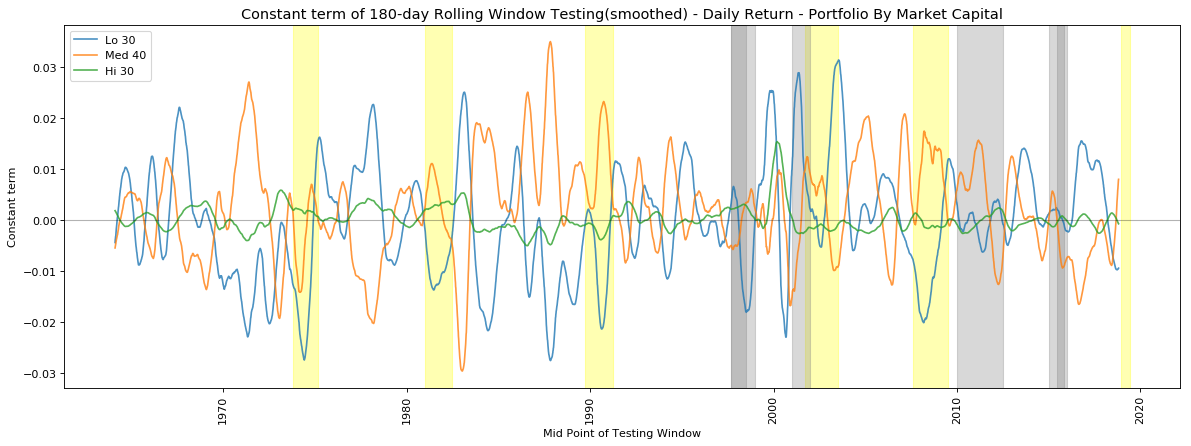

In [30]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = Constant["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Constant term', size = 10, rotation = 90)
plt.title('Constant term of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(linewidth=1, color='black', alpha = 0.3)
plt.grid(False)
plt.show()

In [34]:
Constant['Portfoio0']

1963-09-30   -0.020399
1963-10-01   -0.019310
1963-10-02   -0.016674
1963-10-03   -0.015913
1963-10-04   -0.015816
1963-10-07   -0.016026
1963-10-08   -0.015491
1963-10-09   -0.014802
1963-10-10   -0.015105
1963-10-11   -0.016683
1963-10-14   -0.015401
1963-10-15   -0.016088
1963-10-16   -0.017066
1963-10-17   -0.016437
1963-10-18   -0.015855
1963-10-21   -0.015856
1963-10-22   -0.017513
1963-10-23   -0.017866
1963-10-24   -0.014445
1963-10-25   -0.014378
1963-10-28   -0.013798
1963-10-29   -0.014355
1963-10-30   -0.013155
1963-10-31   -0.011995
1963-11-01   -0.012406
1963-11-04   -0.012980
1963-11-06   -0.012012
1963-11-07   -0.010865
1963-11-08   -0.010045
1963-11-11   -0.010850
                ...   
2019-01-18   -0.007100
2019-01-22   -0.007716
2019-01-23   -0.007699
2019-01-24   -0.007054
2019-01-25   -0.006948
2019-01-28   -0.006913
2019-01-29   -0.006290
2019-01-30   -0.007234
2019-01-31   -0.005112
2019-02-01   -0.006825
2019-02-04   -0.005507
2019-02-05   -0.004474
2019-02-06 

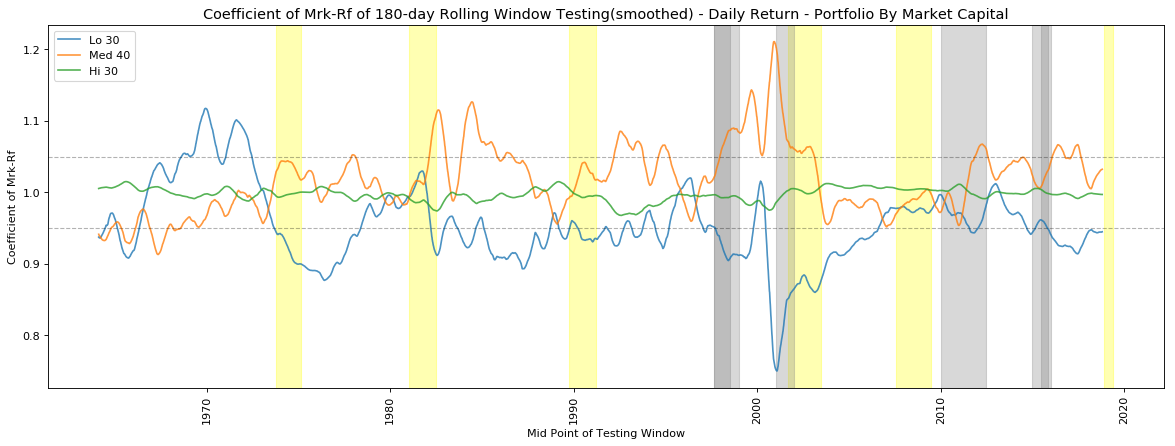

In [26]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = Mrk["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of Mrk-Rf', size = 10, rotation = 90)
plt.title('Coefficient of Mrk-Rf of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(y = 1.05, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.axhline(y = 0.95, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)
plt.show()

/home/whan/miniconda3/envs/eqai/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


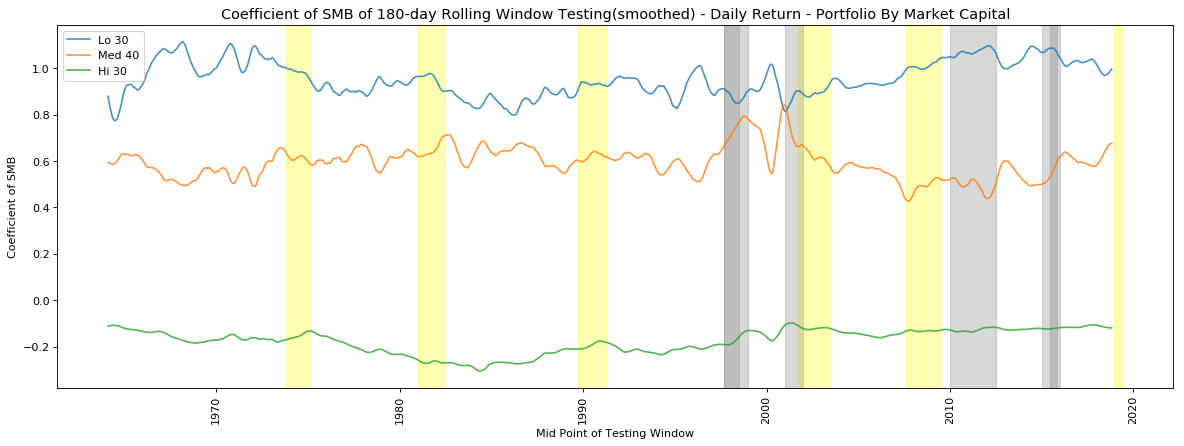

In [25]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = SMB["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of SMB', size = 10, rotation = 90)
plt.title('Coefficient of SMB of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.grid(False)

plt.show()

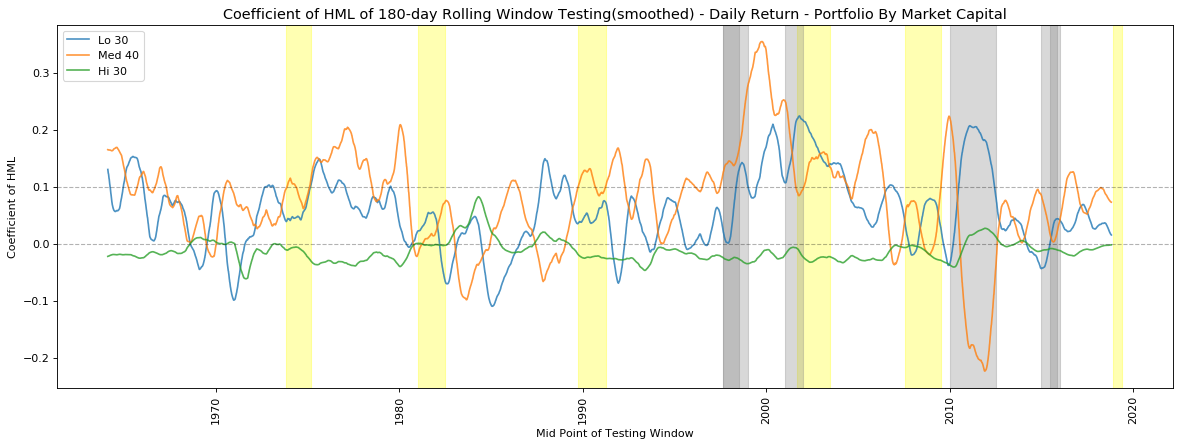

In [17]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = HML["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of HML', size = 10, rotation = 90)
plt.title('Coefficient of HML of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(y = 0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.axhline(y = 0, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

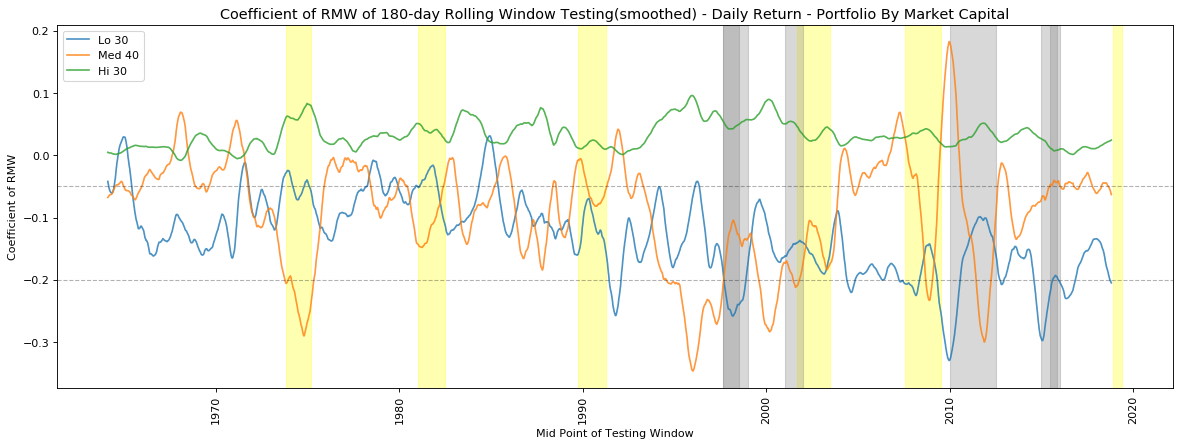

In [18]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = RMW["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of RMW', size = 10, rotation = 90)
plt.title('Coefficient of RMW of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(y = -0.05, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.axhline(y = -0.2, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

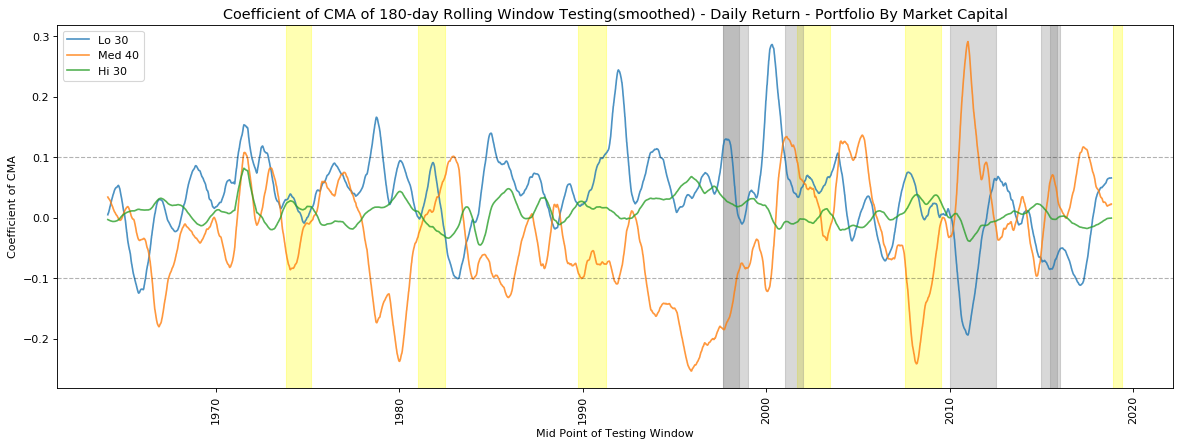

In [19]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = CMA["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('Coefficient of CMA', size = 10, rotation = 90)
plt.title('Coefficient of CMA of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')

plt.axhline(y = 0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.axhline(y = -0.1, linewidth=1, color='black',alpha=0.3, linestyle = '--')
plt.grid(False)

plt.show()

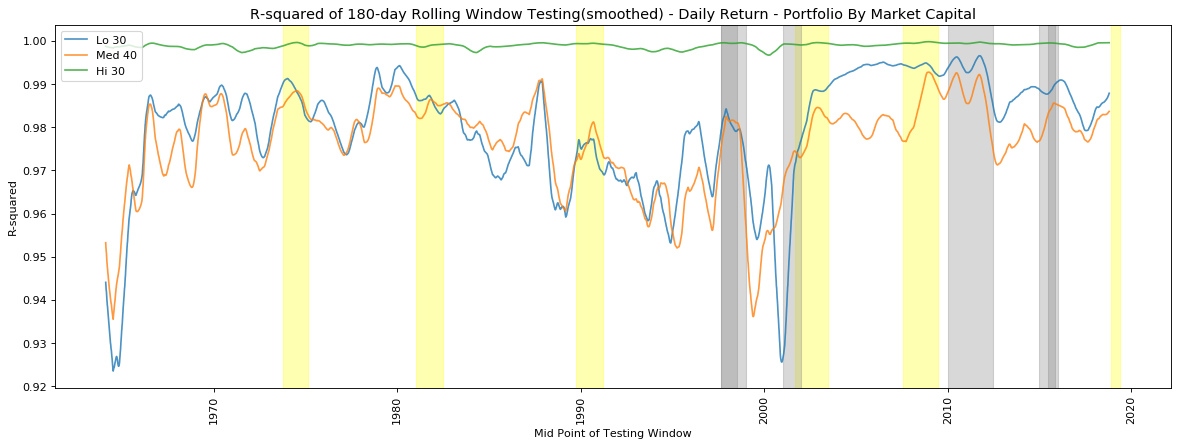

In [20]:
# To further smooth the coefficients
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
for i in range(3):
    rolling_mean = Rsquare["Portfoio{0}".format(i)].rolling(window=180, center = True).mean()
    plt.plot(rolling_mean,label=portfolio[i],alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel('Mid Point of Testing Window', size = 10)
plt.ylabel('R-squared', size = 10, rotation = 90)
plt.title('R-squared of 180-day Rolling Window Testing(smoothed) - Daily Return - Portfolio By Market Capital', size = 13)
plt.xticks(size = 10)
plt.legend(loc='upper left')
plt.axvspan(us_crisis_1[0], us_crisis_1[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_2[0], us_crisis_2[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_3[0], us_crisis_3[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_4[0], us_crisis_4[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_5[0], us_crisis_5[1], alpha=0.3, color='yellow')
plt.axvspan(us_crisis_6[0], us_crisis_6[1], alpha=0.3, color='yellow')
plt.axvspan(other_crisis_1[0], other_crisis_1[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_2[0], other_crisis_2[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_3[0], other_crisis_3[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_4[0], other_crisis_4[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_5[0], other_crisis_5[1], alpha=0.3, color='Grey')
plt.axvspan(other_crisis_6[0], other_crisis_6[1], alpha=0.3, color='Grey')
plt.show()

In [40]:
x = HML["Portfoio0"].rolling(window=180, center = True).mean()
y = HML["Portfoio1"].rolling(window=180, center = True).mean()
x = x.dropna()
y = y.dropna()
print(len(y))
print(len(x))
print(y.head())
print(x.head())
y_shift = y.shift(-252)
print(y_shift.head())
x = sm.add_constant(x)
reg = sm.OLS(y.shift(252), x, missing = 'drop')
reg.fit()
print(reg.fit().summary())

13771
13771
1964-02-10    0.165197
1964-02-11    0.165094
1964-02-12    0.165028
1964-02-13    0.164984
1964-02-14    0.164910
dtype: float64
1964-02-10    0.130465
1964-02-11    0.129714
1964-02-12    0.128806
1964-02-13    0.127850
1964-02-14    0.126927
dtype: float64
1964-02-10    0.114814
1964-02-11    0.114154
1964-02-12    0.113514
1964-02-13    0.112891
1964-02-14    0.112231
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     3200.
Date:                Sun, 07 Jul 2019   Prob (F-statistic):               0.00
Time:                        22:24:51   Log-Likelihood:                 14952.
No. Observations:               13519   AIC:                        -2.990e+04
Df Residuals:                   13517   BIC: 

In [41]:
x = RMW["Portfoio0"].rolling(window=180, center = True).mean()
y = RMW["Portfoio1"].rolling(window=180, center = True).mean()
x = x.dropna()
y = y.dropna()
print(len(y))
print(len(x))
print(y.head())
print(x.head())
y_shift = y.shift(-252)
print(y_shift.head())
x = sm.add_constant(x)
reg = sm.OLS(y.shift(252), x, missing = 'drop')
reg.fit()
print(reg.fit().summary())

13771
13771
1964-02-10   -0.067711
1964-02-11   -0.067547
1964-02-12   -0.067404
1964-02-13   -0.067240
1964-02-14   -0.067129
dtype: float64
1964-02-10   -0.041926
1964-02-11   -0.042409
1964-02-12   -0.042932
1964-02-13   -0.043434
1964-02-14   -0.043946
dtype: float64
1964-02-10   -0.056415
1964-02-11   -0.056379
1964-02-12   -0.056332
1964-02-13   -0.056287
1964-02-14   -0.056237
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 07 Jul 2019   Prob (F-statistic):           1.44e-55
Time:                        22:28:35   Log-Likelihood:                 13809.
No. Observations:               13519   AIC:                        -2.761e+04
Df Residuals:                   13517   BIC: 